In [12]:
using LogicCircuits
using ProbabilisticCircuits
using DataFrames
using BenchmarkTools
using TikzPictures
using Statistics: mean
using LinearAlgebra: normalize
using Clustering: kmeans, nclusters, assignments
TikzPictures.standaloneWorkaround(true)

Just manually building a circuit by hand and plotting it

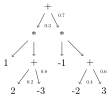

In [13]:
X1, X2, X3 = literals(ProbCircuit, 3)
pc = 0.3 * (X1[1] * 
             (0.2X2[1] + 0.8X3[2])) + 
     0.7 * (X1[2] *
             (0.4X2[2] + 0.6X3[1]))
plot(pc)

<p>Using the NLTCS data set (16 Boolean features)</p>
<p>16181 + 2157 + 3236 rows for training/validation/testing</p>

In [14]:
train_x, valid_x, test_x = twenty_datasets("nltcs")
println(size(train_x))
println(size(valid_x))
println(size(test_x))

(16181, 16)
(2157, 16)
(3236, 16)


Using a balanced vtree, parsing its left and right variable on the root and plotting it

BitSet([1, 2, 3, 4, 5, 6, 7, 8])
BitSet([9, 10, 11, 12, 13, 14, 15, 16])


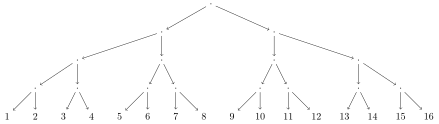

In [15]:
vtree = Vtree(num_features(train_x), :balanced)
println(vtree.left.variables)
println(vtree.right.variables)
plot(vtree)

Training a fully factorized circuit and plotting it

Circuits has 79 nodes, 48 parameters.


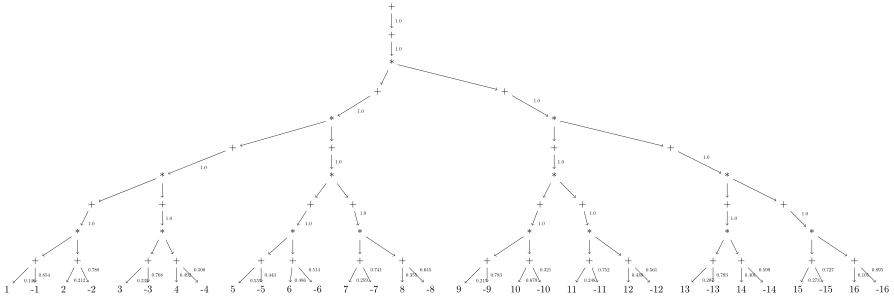

In [16]:
pc = fully_factorized_circuit(StructProbCircuit, vtree);
estimate_parameters(pc, train_x; pseudocount=1.0);
println("Circuits has $(num_nodes(pc)) nodes, $(num_parameters(pc)) parameters.")
plot(pc)

Log-likelihoods (values should be bad as the model is very naive)

In [17]:
println("Training set log-likelihood is ", log_likelihood_avg(pc, train_x))
println("Testing set log-likelihood is ", log_likelihood_avg(pc, test_x))
println("Validation set log-likelihood is ", log_likelihood_avg(pc, valid_x))

Training set log-likelihood is -9.270330518351887
Testing set log-likelihood is -9.23360789127908
Validation set log-likelihood is -9.366715335539586


Smarter learning based on Chow-Liu algorithm

In [18]:
pc_cl, vtree_cl = learn_chow_liu_tree_circuit(train_x)

(StructSumNode(6378938910086917638), PlainVtreeInnerNode(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))

Plotting such (better?) vtree

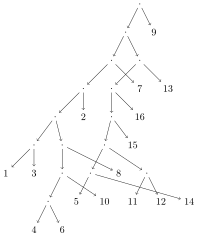

In [19]:
plot(vtree_cl)

Plotting the circuit (it has more nodes and parameters)

Circuits has 121 nodes, 74 parameters.


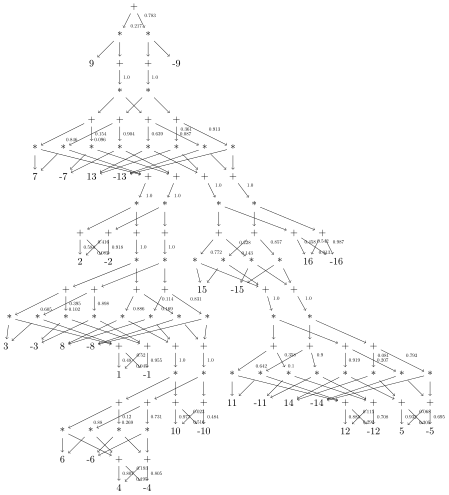

In [20]:
println("Circuits has $(num_nodes(pc_cl)) nodes, $(num_parameters(pc_cl)) parameters.")
plot(pc_cl)

Such model gives a better (=higher) likelihood

In [21]:
println("Training set log-likelihood is ", log_likelihood_avg(pc_cl, train_x))

Training set log-likelihood is -6.7600561877107


<h1>Our LearnPSDD algorithm (manual version)</h1>

In [23]:
nd = 1000
d = train_x[1:nd,:] # Using fewer data for quicker tests
#d = train_x[:,:]

vtree = vtree_cl

if typeof(vtree.left) == PlainVtreeLeafNode # If there is a single variable on the left
    idx_left = variable(vtree.left) # parsing the index of the variable on the left
    d_left = d[:,idx_left] # extracting the data on that row
    n = size(d_left)[1] # counting the number of rows
    theta_left = [n-sum(d_left),sum(d_left)]/n # computing the two thetas for X=0 and X=1
    
    y = variables(vtree.right) # parsing the indexes of the variables on the right DEBUG: case of a single var
    yy = (x->collect.(x)).(y)
    b = zeros(Int8,size(yy,1))
    for i = 1:size(yy,1)
        b[i] = yy[i][1]
    end
    
    # taking the data when the variable on the left is 0 and 1
    d_right1 = d[d[:,idx_left] .== 1, :]
    d_right0 = d[d[:,idx_left] .== 0, :]
    
    # focusing on the right variables/columns only
    d_right1 = d_right1[:,b]
    d_right0 = d_right0[:,b]

    # clustering the data
    d_rightc1 = clustering(d_right1,3)
    d_rightc0 = clustering(d_right0,3)

    # computing the thetas on the basis of the dimensions of the clusters
    theta_right0 = [size(d_rightc0[1],1),size(d_rightc0[2],1),size(d_rightc0[3],1)]/size(d_right0,1)
    theta_right1 = [size(d_rightc1[1],1),size(d_rightc1[2],1),size(d_rightc1[3],1)]/size(d_right1,1)
    println(theta_left)
    println(theta_right0)
    println(theta_right1)
else
    println("to do")
end

0.813 0.187
0.5129151291512916 0.25584255842558423 0.23124231242312424
0.39572192513368987 0.26737967914438504 0.33689839572192515
